In [1]:
%load_ext Cython
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
%load_ext autoreload
%load_ext autotime
%autoreload 2

time: 302 µs


In [2]:
%%cython
import numpy as np
import NAFFlib as naff
cimport numpy as np

cdef double tune = 0.205 # Tune of the system
cdef double mu = 2*np.pi*tune # mu of the system
cdef double xrange = 0.8 # Range of x values to test: -xrange to xrange
cdef double pxrange = 0.8 # Range of px values to test: -pxrange to pxrange

cdef int Nx = 100 # Number of x samples to take
cdef int Npx = Nx//2 # Number of px samples to take
cdef int Nt = Nx*Npx # Total number of test particles
cdef int shift = 0 # Number of turns to calculate before starting to store tracking values
cdef int N = 1000 # Number of turns to calculate for each particle after the shift

xarr = [] # Array to store x tracking values
pxarr = [] # Array to store px tracking values
tune_diff = [] # Array to store the tune differences
pyNt = int(Nt*1.) # Python variable to store total number of particles to use outsite cell
pyshift = int(shift*1.) # Python variable to store shift to use outsite cell
pyN = int(N*1.) # Python variable to store number of turns to use outside cell
pytune = float(tune*1.) # Python variable to store tune to use outside cell

x=np.linspace(-xrange, xrange, Nx) # Creating x values
px=np.linspace(-pxrange, pxrange, Npx) # Creating px values

xx,ppx=np.meshgrid(x, px) # Creating grid of test values

xx=xx.flatten() # Reshaping x
ppx=ppx.flatten() # Reshaping px

xarr.append(xx) # Adding initial values
pxarr.append(ppx)

cdef np.ndarray mat=np.array([[np.cos(mu), np.sin(mu)],[-np.sin(mu),np.cos(mu)]]) # Transformation matrix

cdef int i
for i in range(shift):
    # Particle tracking for x number of turns
    temp = mat.dot([xx,ppx-xx*xx])
    xx,ppx=temp[0],temp[1]

for i in range(N):
    # particle tracking for x number of turns
    temp = mat.dot([xx,ppx-xx*xx])
    xarr.append(temp[0])
    pxarr.append(temp[1])
    xx,ppx=temp[0],temp[1]

xarr = np.array(xarr)  # Converting arrays to numpy arrays for slicing to work
pxarr = np.array(pxarr)

nan_index = []
for i in range(Nt):
    # Finding the tune difference for each test particle
    if np.isnan(np.max(xarr[:,i])):
        nan_index.append(i)
    else:
        tune_diff.append(tune - naff.get_tune(xarr[:,i]))

<frozen importlib._bootstrap>:219: RuntimeWarning: overflow encountered in multiply


time: 1.52 s


In [3]:
from sklearn.model_selection import train_test_split

datain=np.array([xarr[0,:],pxarr[0,:]]) # Initial conditions for the particles
dataout=np.array([xarr[-1,:], pxarr[-1,:]]) # Final position of the particles

dim1, dim2 = np.shape(dataout)
index = []

for i in range(dim1):
    for j in range(dim2):
        if np.isnan(dataout[i,j]):
            index.append(j)

datain = np.array(np.delete(datain, index, 1))
dataout = np.array(np.delete(dataout, index, 1))

datain = datain.T
dataout = dataout.T

testin, trainin, testout, trainout = train_test_split(datain, dataout, test_size=0.33, random_state=42)

time: 619 ms


In [4]:
 from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(trainin, trainout)

LinearRegression()

time: 47.2 ms


In [5]:
pred = model.predict(testin)

pred = pred.T
datain = datain.T
dataout = dataout.T
testin=testin.T
trainin=trainin.T
testout=testout.T
trainout=trainout.T


time: 1.1 ms


<IPython.core.display.Javascript object>


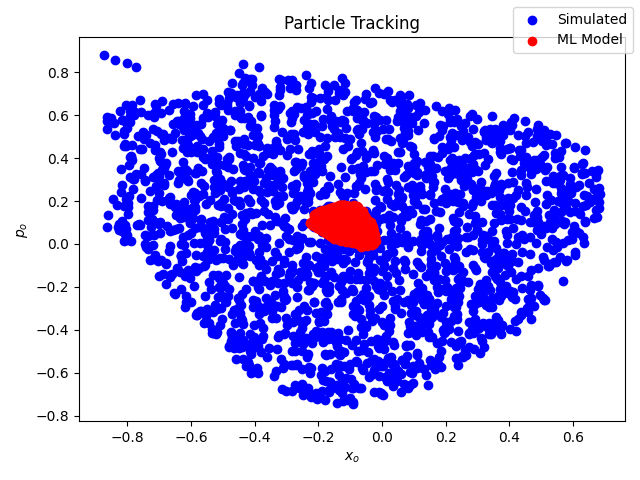

time: 161 ms


In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('$x_o$')
ax.set_ylabel('$p_o$')
ax.set_title("Particle Tracking")

ax.scatter(testout[0,:], testout[1,:], c='b', label="Simulated")
ax.scatter(pred[0,:], pred[1,:], c='r', label="ML Model")

fig.legend()
fig.tight_layout()

In [7]:
Fdatain = np.array([np.delete(xarr[0,:], nan_index), np.delete(pxarr[0,:], nan_index)])

Fdatain = Fdatain.T

Ftestin, Ftrainin, Ftestout, Ftrainout = train_test_split(Fdatain, tune_diff, test_size=0.33, random_state=42)

time: 2.57 ms


In [8]:
Fmodel = LinearRegression()
Fmodel.fit(Ftrainin, Ftrainout)

LinearRegression()

time: 3.41 ms


In [9]:
Fpred = Fmodel.predict(Ftestin)

Ftestout = np.array(Ftestout)
Ftrainout = np.array(Ftrainout)

Fpred=Fpred.T
Ftestin=Ftestin.T
Ftrainin=Ftrainin.T
Ftestout=Ftestout.T
Ftrainout=Ftrainout.T

time: 1.46 ms


<IPython.core.display.Javascript object>


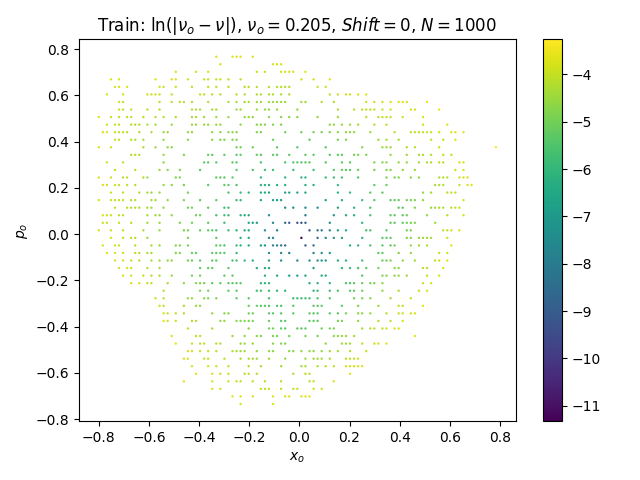

time: 111 ms


In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('$x_o$')
ax.set_ylabel('$p_o$')
ax.set_title('Train: $\ln(|\\nu_o - \\nu|)$, $\\nu_o={tune}$, $Shift={shift}$, $N={turns}$'.format(tune=pytune, shift=pyshift, turns=pyN))

im = ax.scatter(Ftrainin[0,:], Ftrainin[1,:], c=np.log(np.abs(Ftrainout) + 1e-15), s=0.5)

fig.tight_layout()
fig.colorbar(im)

<IPython.core.display.Javascript object>


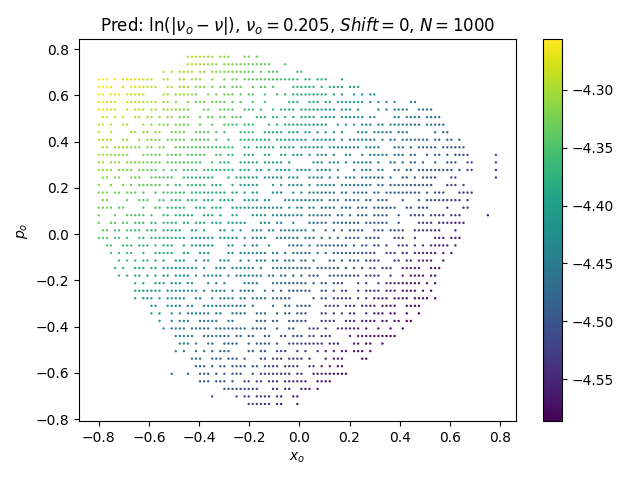

time: 107 ms


In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('$x_o$')
ax.set_ylabel('$p_o$')
ax.set_title('Pred: $\ln(|\\nu_o - \\nu|)$, $\\nu_o={tune}$, $Shift={shift}$, $N={turns}$'.format(tune=pytune, shift=pyshift, turns=pyN))

im = ax.scatter(Ftestin[0,:], Ftestin[1,:], c=np.log(np.abs(Fpred) + 1e-15), s=0.5)

fig.tight_layout()
fig.colorbar(im)

<IPython.core.display.Javascript object>


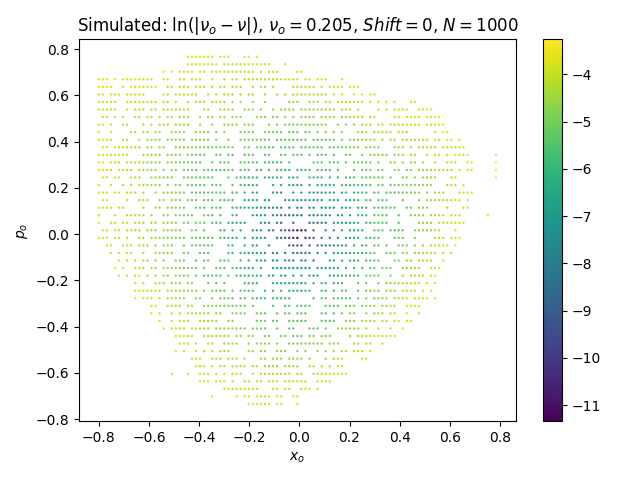

time: 107 ms


In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('$x_o$')
ax.set_ylabel('$p_o$')
ax.set_title('Simulated: $\ln(|\\nu_o - \\nu|)$, $\\nu_o={tune}$, $Shift={shift}$, $N={turns}$'.format(tune=pytune, shift=pyshift, turns=pyN))

im = ax.scatter(Ftestin[0,:], Ftestin[1,:], c=np.log(np.abs(Ftestout) + 1e-15), s=0.5)

fig.tight_layout()
fig.colorbar(im)

In [13]:
x=np.linspace(-1, 1, 500) # Creating x values
px=np.linspace(-1, 1, 500) # Creating px values

xx,ppx=np.meshgrid(x, px) # Creating grid of test values

xx=xx.flatten() # Reshaping x
ppx=ppx.flatten() # Reshaping px

newtestin = np.array([xx,ppx])

pred = model.predict(newtestin.T)

pred = pred.T

time: 30.7 ms


<IPython.core.display.Javascript object>


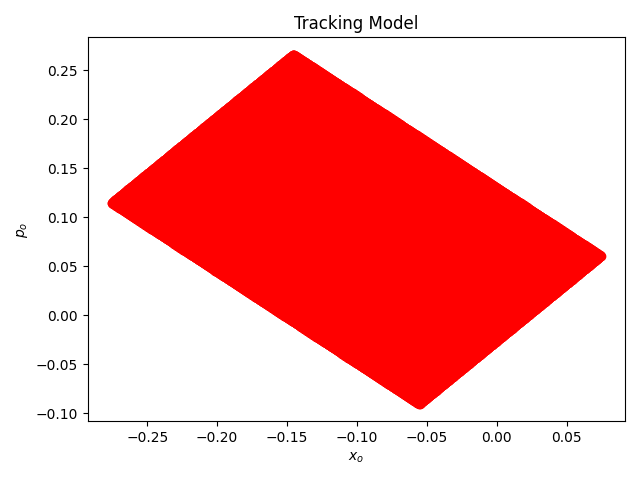

time: 104 ms


In [14]:
fig, ax = plt.subplots()
ax.set_xlabel('$x_o$')
ax.set_ylabel('$p_o$')
ax.set_title("Tracking Model")

im = ax.scatter(pred[0,:], pred[1,:], c='r', label="ML Model")

fig.tight_layout()